# Project Steps
 ## Main Steps:

* Camera calibration and distortion correction.
* Color/gradient threshold.
* Perspective transform.
* Detect lane lines.

## Extra Step:
* Determine the lane curvature.

In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from matplotlib.patches import Polygon
%matplotlib inline

# Camera Calibration  and Distortion Correction

In [27]:
def cameraCalibrate(image):
    # Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    import glob

    #read in and make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    #Arrays to store objects points and image points from all the images
    objpoints = [] #3d points
    imgpoints = [] #2d points

    #prepare points
    objp  = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


    for fname in images:
        #read in each image
        img = mpimg.imread(fname)
        #convert image to gray scale  
        gray  = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        #find corners  
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    shape =(img.shape[1],img.shape[0])
    ret, mtx, dist, rvect, tvect = cv2.calibrateCamera(objpoints,imgpoints,shape,None,None)
    
    #undistored the image
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_image

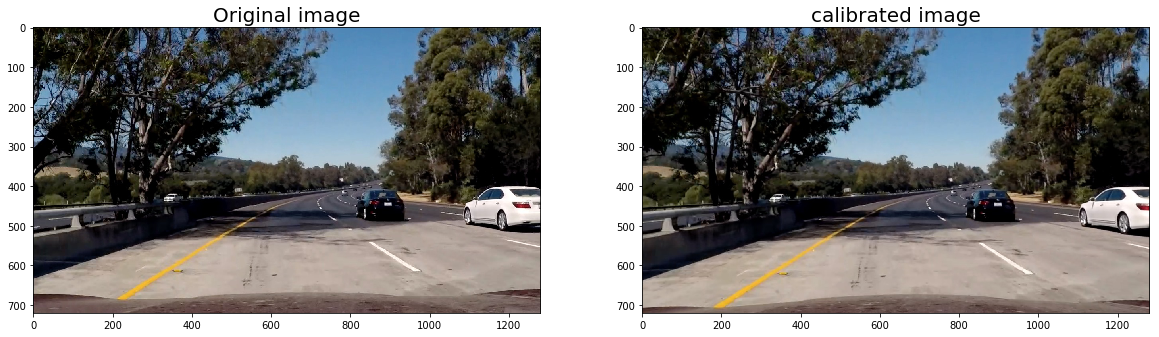

In [28]:
test_image = mpimg.imread('./test_images/test5.jpg')

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image', fontsize=20)
ax1.imshow(test_image)
ax2.set_title('calibrated image', fontsize=20)
test_image=cameraCalibrate(test_image)
ax2.imshow(test_image)

# Gradient / Color Threshold

In [43]:
#-----------mayar--------------
#GAUSSIAN BLUR
blurred = cv2.GaussianBlur(test_image, (5,5), 0)


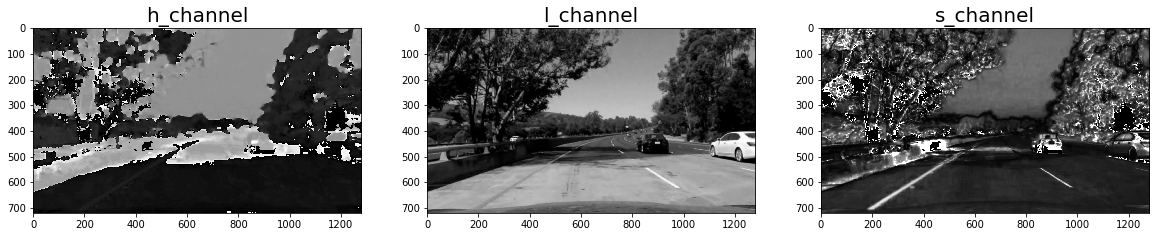

In [44]:
#TODO: Convert to H
hlsval = cv2.cvtColor(blurred,cv2.COLOR_RGB2HLS)

h_channel,l_channel,s_channel=cv2.split(hlsval)
# visualize
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('h_channel', fontsize=20)
ax1.imshow(h_channel,cmap='gray')
ax2.set_title('l_channel', fontsize=20)
ax2.imshow(l_channel,cmap='gray')
ax3.set_title('s_channel', fontsize=20)
ax3.imshow(s_channel,cmap='gray')

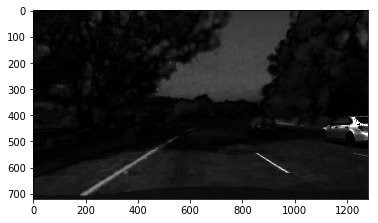

In [45]:
plt.imshow((l_channel/255)*(s_channel/255),cmap="gray")

In [46]:
def colorThreshold(img,thresh=(0.35,1)):
    hlsval = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    h_channel,l_channel,s_channel=cv2.split(hlsval)
    combinedcolor=(l_channel/255)*(s_channel/255)
    ret,thresh=cv2.threshold(combinedcolor,thresh[0],thresh[1],cv2.THRESH_BINARY)
    return thresh
    

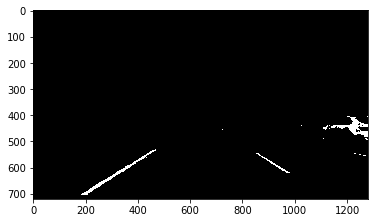

In [47]:
plt.imshow(colorThreshold(test_image),cmap="gray")

In [12]:
# X or Y sobel gradient
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 250)):
    # TODO: Convert to grayscale using cv2.COLOR_RGB2GRAY as the conversion
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # TODO: Apply x or y gradient with the OpenCV Sobel() function

    ddepth = cv2.CV_64F    
    # and take the absolute value
    if(orient=='x'):
        grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=sobel_kernel)
        abs_sobel=np.absolute(grad_x)
    if(orient=='y'):
        grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=sobel_kernel)
        abs_sobel=np.absolute(grad_y)   
    # TODO: Rescale back to 8 bit integer
    abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # TODO: Create a binary image of ones where threshold is met, zeros otherwise
    abs_sobel_output = np.zeros_like(abs_sobel)
    for i in range(0,abs_sobel.shape[0]):
        for j in range(0,abs_sobel.shape[1]):
            if abs_sobel[i][j]>thresh[0] and abs_sobel[i][j]<thresh[1]:
                abs_sobel_output[i][j]=1   

    # Return the binary image
    return abs_sobel_output

# Magnitude using X and Y sobel gradient
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # TODO: Convert to grayscale using cv2.COLOR_RGB2GRAY as the conversion
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_64F    
    
   
    # TODO: Calculate the gradient magnitude
    sobelx=np.absolute(cv2.Sobel(gray, ddepth, 1, 0, ksize=sobel_kernel))
    sobely=np.absolute(cv2.Sobel(gray, ddepth, 0, 1, ksize=sobel_kernel))
    
    sobelx=np.square(sobelx)
    sobely=np.square(sobely)
    sobelxy=sobelx+sobely
    gradmag=np.sqrt(sobelxy)
    
    # TODO:  Rescale to 8 bit
    gradmag = np.uint8(255*gradmag/np.max(gradmag))
   
    # TODO: Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    for i in range(0,gradmag.shape[0]):
        for j in range(0,gradmag.shape[1]):
            if gradmag[i][j]>mag_thresh[0] and gradmag[i][j]<mag_thresh[1]:
                mag_binary[i][j]=1     
    # Return the binary image
    return mag_binary

# Direction using X and Y sobel gradient
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # TODO: Convert to grayscale using cv2.COLOR_RGB2GRAY as the conversion
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_64F     
    # TODO: Calculate the gradient direction using np.arctan2 function
    sobelx=cv2.Sobel(gray, ddepth, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, ddepth, 0, 1, ksize=sobel_kernel)
    absgraddir = np.absolute(np.arctan2(sobely, sobelx))
    # TODO: Rescale to 8 bit
    absgraddir = np.uint8(255*absgraddir/np.max(absgraddir))
   
    # TODO: Create a binary image of ones where threshold is met, zeros otherwise    
    dir_binary =  np.zeros_like(absgraddir)
    for i in range(0,absgraddir.shape[0]):
        for j in range(0,absgraddir.shape[1]):
            if absgraddir[i][j]>thresh[0] and absgraddir[i][j]<thresh[1]:
                dir_binary[i][j]=1     
    # Return the binary image
    return dir_binary

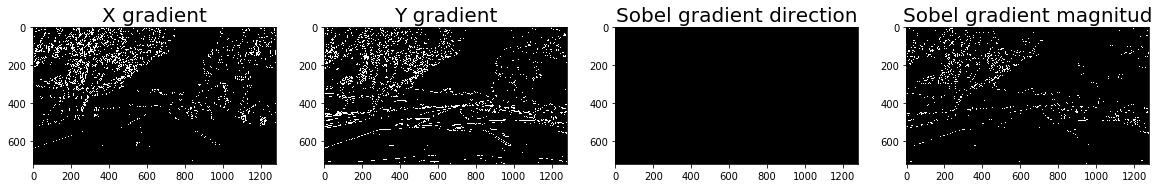

In [38]:
colorGradientImage=colorThreshold(test_image)

# X gradient
x_sobel=abs_sobel_thresh(test_image,orient="x",thresh=(30, 100))
# Y gradient
y_sobel=abs_sobel_thresh(test_image,orient="y",thresh=(30, 100))
# Sobel gradient direction
mag_sobel=mag_thresh(test_image, sobel_kernel=3, mag_thresh=(60, 100))
# Sobel gradient magnitude
dir_sobel=dir_threshold(test_image, sobel_kernel=3, thresh=(0, np.pi/2))

# visualize results
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,10))
# X gradient
ax1.set_title('X gradient', fontsize=20)
ax1.imshow(x_sobel,cmap='gray')
# Y gradient
ax2.set_title('Y gradient', fontsize=20)
ax2.imshow(y_sobel,cmap='gray')
# Sobel gradient direction
ax3.set_title('Sobel gradient direction', fontsize=20)
ax3.imshow(dir_sobel,cmap='gray')
# Sobel gradient magnitude
ax4.set_title('Sobel gradient magnitud', fontsize=20)
ax4.imshow(mag_sobel,cmap='gray')

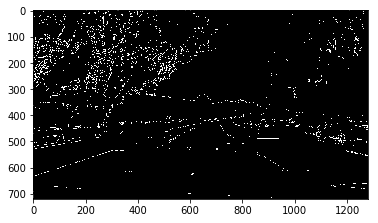

In [39]:
image = mpimg.imread('./test_images/test5.jpg')
plt.imshow(mag_thresh(image, mag_thresh=(60,100)), cmap='gray')

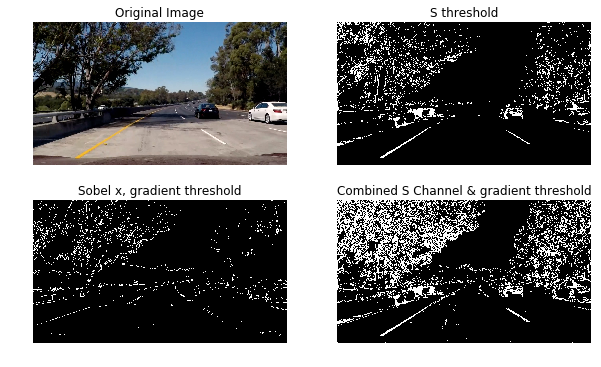

In [40]:
def Color(img, threshold = (90,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > threshold[0]) & (S <= threshold[1])] = 1
    return binary


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def Gradient(img, threshold = (0,255)):
    # Choose a Sobel kernel size
    ksize = 5  # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=threshold)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=threshold)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=threshold)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(-np.pi / 2, np.pi / 2))
    combined = np.zeros_like(dir_binary)
    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined


def CombineGradientColor(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Note: img is the undistorted image
    # img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
     # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary


def visualize(img):
    """Plot the images for README"""
    image = mpimg.imread('./test_images/test5.jpg')
    # CombineColorGradient
    f, axes = plt.subplots(2, 2, figsize=(10, 6))
    (ax1, ax2, ax3, ax4) = axes.ravel()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=12)
    ax2.imshow(Color(image, threshold=(170,255)), cmap='gray')
    ax2.set_title('S threshold', fontsize=12)
    ax3.imshow(Gradient(image, threshold=(60,100)), cmap='gray')
    ax3.set_title('Sobel x, gradient threshold', fontsize=12)
    ax4.imshow(CombineGradientColor(image, s_thresh=(170,255), sx_thresh=(20,100)),
               cmap='gray')
    ax4.set_title('Combined S Channel & gradient threshold', fontsize=12)
    for ax in axes.ravel():
        ax.axis('off')



# Plot the result

# plt.figure()
# plt.imshow(gradientImg, cmap='gray')
# plt.show()
image = mpimg.imread('./test_images/test5.jpg')
visualize(image)

# Perspective Transform

In [52]:
def warp(img, src_coordinates=None, dst_coordinates=None):

    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
 
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

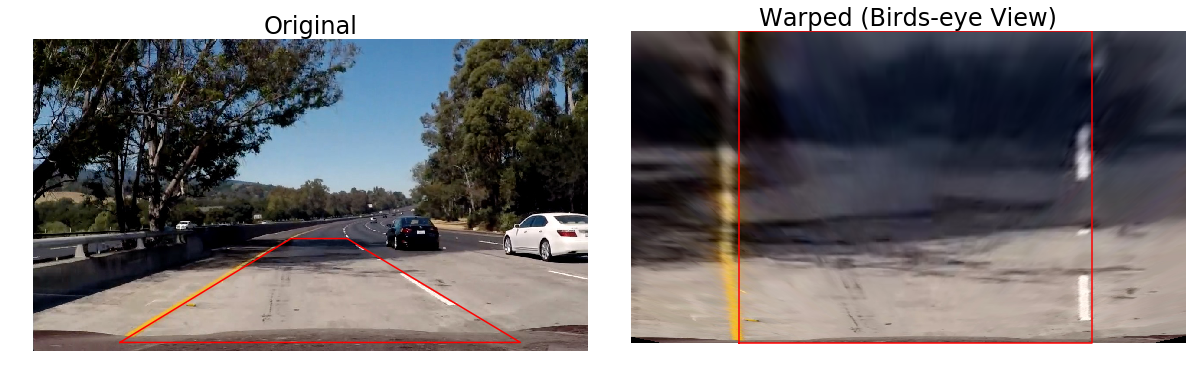

In [62]:
src_coordinates = np.float32(
    [#[280,  700],
     [200, 700],# Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst_coordinates = np.float32(
    [[250,  720],   # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   

coordinates = [src_coordinates,dst_coordinates]

#WARP BINARY IMAGE INTO TOP-DOWN VIEW
warped, M, Minv = warp(image, src_coordinates, dst_coordinates)

# Plot the result
imgs = [image, warped]
names = ['Original' ,'Warped (Birds-eye View)']

f, ax = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
i = 0
for c in range(2):
    ax[c].imshow(imgs[i], cmap='gray')
    ax[c].plot(Polygon(coordinates[i]).get_xy()[:, 0], Polygon(coordinates[i]).get_xy()[:, 1], color='red')
    warped, M, Minv = warp(test_image) #yasmeen's output
    ax[c].set_title('{}'.format(names[i]), fontsize=24)
    ax[c].axis('off')
    i += 1

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Detect Lane Lines

After finishing the previous steps You now have a thresholded warped image and you're ready to map out the lane lines! There are many ways you could go about this, but here's one example of how you might do it:
### Peaks in a Histogram and Sliding Windows
* After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.
* we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.
#### steps:
  1. split the histogram into two sides, one for each lane line.
  2. Set up sliding windows and window hyperparameters:
     * set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image. These hyperparameters are:
        1. **W_Number**; number of sliding windows.
        2. **Margin**; the width of each window.
        3. **Minimum_pixels**; used as a threshold to recenter the next sliding window.
        4. **Window_Height**; computed from number of pixels and image height.
  3. Loop through each window in W_Number.
  4. Find the boundaries of our current window. This is based on a combination of the current window's starting point      , as well as the margin you set in the hyperparameters.
  5. Use cv2.rectangle to draw these window boundaries onto visualization image.
  6. Now that we know the boundaries of our window, find out which activated(non zero) pixels actually fall into the window.
  7. Append these non zero pixels to two different arrays one for the right line and the other for the left line.
  8. If the number of pixels you found in Step **6** are greater than your hyperparameter Minimum_pixels, re-center our window based on the mean position of these pixels.
  9. Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line.

### 1- Histogram

516 1828


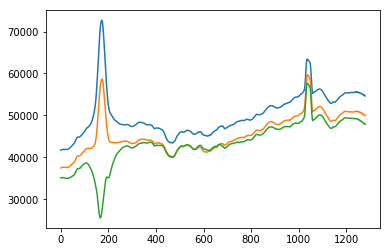

In [66]:
#The peaks int the histogram tell us about the likely position of the lanes in the image.
#---------beter be grayscale, yasmeen's output------------------
def find_histogram_peaks(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Peak in the first half indicates the likely position of the left lane
    half_width = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:half_width])

    # Peak in the second half indicates the likely position of the right lane
    rightx_base = np.argmax(histogram[half_width:]) + half_width
    
    return histogram, leftx_base, rightx_base

histogram, leftx_base, rightx_base = find_histogram_peaks(warped)

print(leftx_base, rightx_base)
plt.plot(histogram)

### 2- Sliding Window

## This function is to draw back the lane on the original image
**N.B.** Add an inverse option in the perspective function so that we can transform the image back to it's original perspective. This can be implemented by swapping **src** and **dst** in cv2.getPerspectiveTransform(src, dst) when a certain flag is set to 1.

In [ ]:
#draw lane
# left_fit and right_fit generated from step 9 in lane Detection
# bird_eye the image after thresholding and perspective transform
# read the inverse note below in the code
def draw_lane(img,bird_eye,left_fit,right_fit):
    tmp_image     = np.copy(img)
    if right_fit is None or left_fit is None:
        return img
    
    zero          = np.zeros_like(bird_eye).astype(np.uint8)
    layered_image = np.dstack((zero,zero,zero))
    
    ploty      = np.linspace(0, bird_eye.shape[0]-1, bird_eye.shape[0] )
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    #formatting the points
    left   = np.array([np.transpose(np.vstack([right_fitx,ploty]))])
    right  = np.array([np.flipud(np.transpose(np.vstack([left_fitx,ploty])))])
    points = np.hstack((left,right))
    
    #form lane
    cv2.fillPoly(layered_image,np.int_([points]),(0,255,0))
    cv2.polylines(layered_image,np.int32([right]),isClosed = False,color=(255,0,0),thickness = 20)
    cv2.polylines(layered_image,np.int32([left]),isClosed = False,color=(255,0,0),thickness = 20)
    
    # The inverse perspective transfom note
    # use the inverse perspective option mentioned in the note above to transform back the layered_image
    inversed = perspective_transform(layered_image,1)
    
    output   = cv2.addWeighted(tmp_image,1,inversed,0.5,0)
    return output

## Determine The Lane Curvature
You're getting very close to a final result! You have a thresholded image, where you've estimated which pixels belong to the left and right lane lines, and you've fit a polynomial to those pixel positions. Next we'll compute the radius of curvature of the fit.

## Curvature in Pixels
In the last step we computed the lane line pixels using their x and y pixel positions to fit a second order polynomial curve: $$f(y) = Ay^2+By+C $$
in this step you will compute the radius of curvature at the closest point to the vehicle.

**Radius of Curvature Equation:**
$$R\_Curve = \frac{[1+(\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}$$

$$f'(y) = \frac{dx}{dy} = 2Ay+B$$

$$f''(y) = \frac{d^2x}{dy^2} =A$$

## From Pixels to Real World
* Great! You've now calculated the radius of curvature for our lane lines. But now we need to stop and think... We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space. So we actually need to repeat this calculation after converting our x and y values to real world space.

* This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide.